# 環境初始化

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.chdir("work/Fatigue-Driving-Detection")
!pwd

/home/jovyan/work/Fatigue-Driving-Detection


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from IPython.display import Image
import matplotlib.pyplot as plt
import json
import random
import time
import utils
import pandas as pd
%matplotlib inline

In [3]:
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

# 資料集格式範例

```json
# 檔案標頭
{
    "file": "1-FemaleNoGlasses-Normal",
    "size": 419,
    "fps": 30,
    "marker_path": "dataset/markers/1-FemaleNoGlasses-Normal.csv",
  "video_path": "dataset/YawDD/train/1-FemaleNoGlasses-Normal.avi"
}

# 標記內容
{
    "index": 1,
    "mode": "Normal",
    "level": "0",
    "mar": 0.025642701314247437,
    "ear_l": 0.2986032435056242,
    "ear_r": 0.3937485488274893,
    "entropy": -16089.327941184894,
    "roll": -2,
    "yaw": 37,
    "pitch": -12
}
```

# 功能函式

In [4]:
def norm_max_min(var, in_min, in_max, out_min=0, out_max=1):
    var = float(var)
    if var >= in_max:
        return out_max
    if var <= in_min:
        return out_min
    return (var - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [5]:
def readDataList(file):
    data_list = []
    with open(file, 'r', encoding='utf-8') as f:
        while True:
            line = f.readline()
            if len(line) == 0: break
            file_json = json.loads(line)
            mlist = []
            for _ in range(file_json['size']):
                mjson = json.loads(f.readline())
                mode = (mjson['mode'] == 'Yawning')
                mar = norm_max_min(mjson['mar'], 0, 1)
                ear_l = norm_max_min(mjson['ear_l'], 0, 1)
                ear_r = norm_max_min(mjson['ear_r'], 0, 1)
                entropy = norm_max_min(mjson['entropy'], 0, 30)
                # roll = norm_max_min(mjson['roll'], -50, 50)
                yaw = norm_max_min(mjson['yaw'], -50, 50)
                # pitch = norm_max_min(mjson['pitch'], -50, 50)
                if yaw >= 0: ear = ear_r
                else: ear = ear_l
                mlist.append(np.array([
                    mode,
                    mar,
                    ear,
                    entropy
                ]))
            data_list.append(np.array(mlist))
    return np.array(data_list)

In [6]:
def buildTrain(data_list, long=300):
  x_data, y_data = [], []
  for t in data_list:
    train = np.array(t)
    for i in range(train.shape[0]-long):
      x_data.append(train[i:i+long,1:])
      y_data.append(train[i+long-1][0])
  return np.array(x_data), np.array(y_data)

In [7]:
random_seed = 0
def shuffle(x_data, y_data):
    np.random.seed(random_seed)
    randomList = np.arange(x_data.shape[0])
    np.random.shuffle(randomList)
    return x_data[randomList], y_data[randomList]

In [8]:
def splitData(data_0, data_1, test_rate):
    data_0_train = data_0[int(data_0.shape[0] * test_rate):]
    data_0_test = data_0[:int(data_0.shape[0] * test_rate)]
    data_1_train = data_1[int(data_1.shape[0] * test_rate):]
    data_1_test = data_1[:int(data_1.shape[0] * test_rate)]
    return data_0_train, data_1_train, data_0_test, data_1_test

# 主程式

##### 建立訓練資料

In [9]:
train_list = readDataList('train_data.txt')
X_trains, Y_train = buildTrain(train_list, 300)
print(X_trains.shape, Y_train.shape)
X_trains, Y_train = shuffle(X_trains, Y_train)
X_trains, Y_train, X_tests, Y_test = splitData(X_trains, Y_train, 0.4)
X_tests, Y_test, X_vals, Y_val = splitData(X_tests, Y_test, 0.5)

<ipython-input-5-49569e82303d>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data_list)


(127739, 300, 3) (127739,)


In [10]:
def seg_data(data):
    seg = [None] * 2
    seg[0] = data[:, :, 0:2] # mar list
    seg[1] = np.average(data[:, :, 2], 1) # entropy
    print(f'{data.shape} -> {seg[0].shape} + {seg[1].shape}')
    return seg

X_train = seg_data(X_trains)
X_val = seg_data(X_vals)
X_test = seg_data(X_tests)

(76644, 300, 3) -> (76644, 300, 2) + (76644,)
(25547, 300, 3) -> (25547, 300, 2) + (25547,)
(25548, 300, 3) -> (25548, 300, 2) + (25548,)


**訓練資料圖形化**

X_data = [23608,:,:], Y_data = 1.0


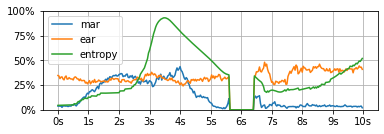

X_data = [46893,:,:], Y_data = 0.0


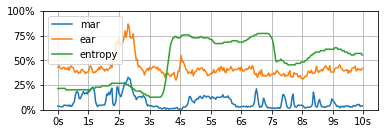

In [11]:
def drawTrain(sub, num):
    plt.subplot(210 + sub)
    plt.plot(X_trains[num,:,0], label='mar')
    plt.plot(X_trains[num,:,1], label='ear')
    plt.plot(X_trains[num,:,2], label='entropy')
    print(f'X_data = [{num},:,:], Y_data = {Y_train[num]}')
    plt.ylim(0, 1)
    plt.legend()
    plt.xticks(np.linspace(0, 300, 11), [f'{int(x)}s' for x in (np.linspace(0,300,11) / 30)])
    plt.yticks(np.linspace(0, 1, 5), [f'{int(x * 100)}%' for x in (np.linspace(0, 1, 5))])
    plt.grid(True)
    plt.show()

def getRnd():
    return random.randint(0, X_trains.shape[0] - 1)

def draw():
    while True:
        rnd = getRnd()
        if Y_train[rnd] > 0.5:
            drawTrain(1, rnd)
            break
    while True:
        rnd = getRnd()
        if Y_train[rnd] <= 0.5:
            drawTrain(2, rnd)
            break
draw()

##### 建立訓練模型

params_num = 1813057
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 300, 2)]     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 150, 64)      448         input_15[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 50, 64)       0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 3200)         0           max_pooling1d_7[0][0]            
_______________________________________________________________________

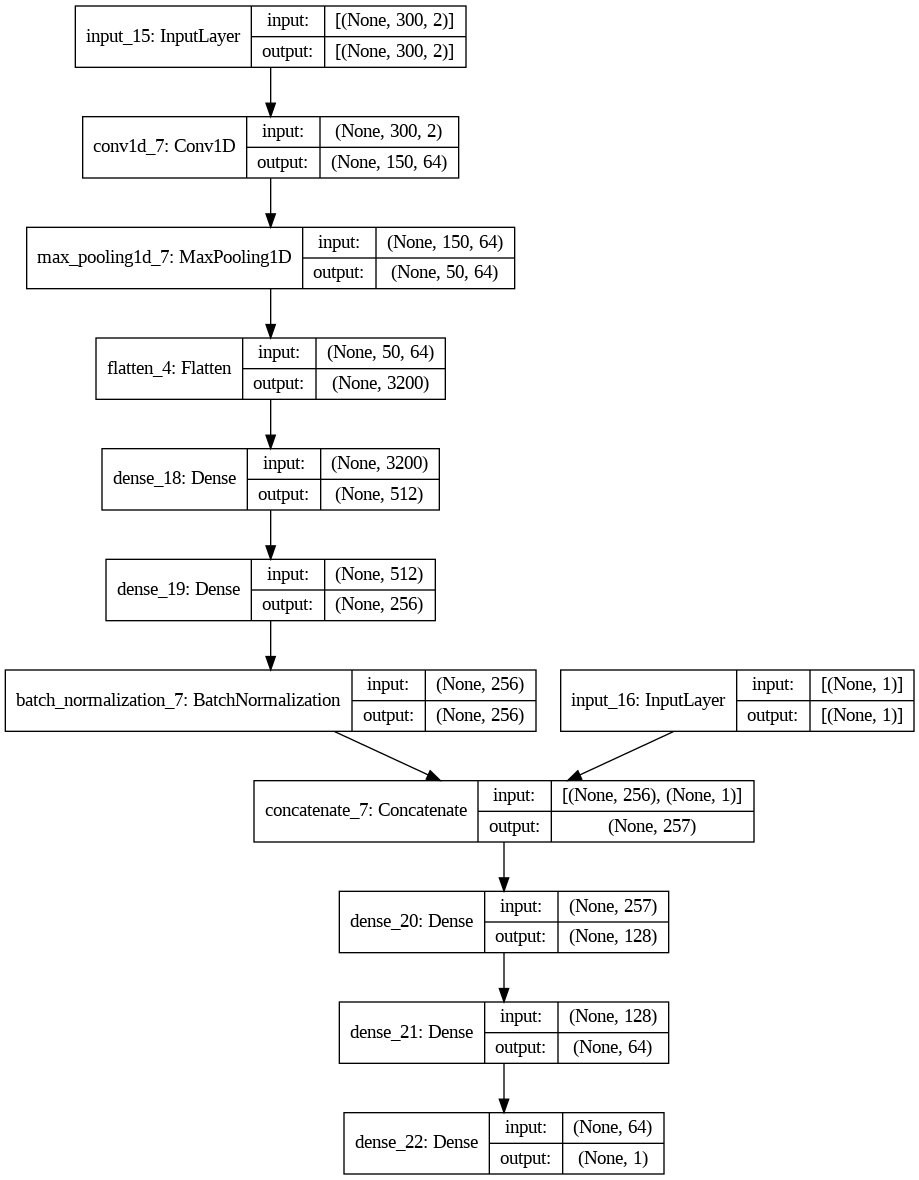

In [19]:
input_1 = keras.Input(shape=(300, 2))
hidden_1 = layers.Conv1D(64, kernel_size=3, strides=2, padding='same', activation="relu", kernel_initializer="he_normal")(input_1)
# hidden_1 = layers.Conv1D(64, kernel_size=2, strides=1, padding='same', activation="relu", kernel_initializer="he_normal")(hidden_1)
hidden_1 = layers.MaxPooling1D(pool_size=3, padding='valid')(hidden_1)
# hidden_1 = layers.BatchNormalization()(hidden_1)
hidden_1 = layers.Flatten()(hidden_1)
# hidden_1 = layers.LSTM(64, return_sequences=True)(hidden_1)
# hidden_1 = layers.Dropout(0.2)(hidden_1)
# hidden_1 = layers.LSTM(64)(hidden_1)
hidden_1 = layers.Dense(512, activation="relu", kernel_initializer="he_normal")(hidden_1)
hidden_1 = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(hidden_1)
hidden_1 = layers.BatchNormalization()(hidden_1)

input_2 = keras.Input(shape=(1, ))

concat = layers.Concatenate(axis=-1)([hidden_1, input_2])
concat_h1 = layers.Dense(128, activation="relu", kernel_initializer="he_normal")(concat)
# concat_h1 = layers.Dropout(0.2)(concat_h1)
concat_h1 = layers.Dense(64, activation="relu", kernel_initializer="he_normal")(concat_h1)
output = layers.Dense(1, activation="sigmoid")(concat_h1)

model = keras.Model(inputs=[input_1, input_2], outputs=[output])
params_num = model.count_params()
print(f'params_num = {params_num}')
model.summary()
plot_model(model, show_shapes=True)

##### 開始訓練

In [20]:
''' trainParam '''
save_models = 'models'
model_tag = 'new'
optimizer = "adam"
loss = "BinaryCrossentropy"
batch_size = 2048
epochs = 10000
time_tag = time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime())
model_dir = f'{time_tag}-{model_tag}-params_{params_num}-batch_{batch_size}'
print(os.path.join(save_models, model_dir))
callbacks = list()
model.compile(optimizer=optimizer, loss=loss, metrics=['BinaryAccuracy'])
''' EarlyStopping '''
callbacks.append(
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")
)
''' ModelCheckpoint '''
model_name = 'epoch_{epoch:03d}-val_loss_{val_loss:.3f}.h5'
all_filepath = os.path.join(save_models, model_dir, 'all_models', model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(all_filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
)
best_filepath = os.path.join(save_models, model_dir, 'model.h5')
callbacks.append(
    keras.callbacks.ModelCheckpoint(best_filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' TensorBoard '''
log_dir = os.path.join(save_models, 'logs', model_dir)
callbacks.append(
    keras.callbacks.TensorBoard(log_dir=log_dir)
)

models/2022_06_09-09_57_30-new-params_1813057-batch_2048


In [21]:
trainHistory = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks=callbacks
)

Epoch 1/10000
38/38 [==============================] - 16s 199ms/step - loss: 0.3819 - binary_accuracy: 0.8277 - val_loss: 0.4358 - val_binary_accuracy: 0.8725
Epoch 2/10000
38/38 [==============================] - 1s 17ms/step - loss: 0.1611 - binary_accuracy: 0.9439 - val_loss: 0.8008 - val_binary_accuracy: 0.5010
Epoch 3/10000
38/38 [==============================] - 1s 16ms/step - loss: 0.1311 - binary_accuracy: 0.9548 - val_loss: 0.2093 - val_binary_accuracy: 0.9156
Epoch 4/10000
38/38 [==============================] - 1s 16ms/step - loss: 0.1154 - binary_accuracy: 0.9608 - val_loss: 1.6364 - val_binary_accuracy: 0.2482
Epoch 5/10000
38/38 [==============================] - 1s 16ms/step - loss: 0.0957 - binary_accuracy: 0.9680 - val_loss: 0.2322 - val_binary_accuracy: 0.9157
Epoch 6/10000
38/38 [==============================] - 1s 16ms/step - loss: 0.0788 - binary_accuracy: 0.9741 - val_loss: 0.4378 - val_binary_accuracy: 0.7914
Epoch 7/10000
38/38 [=============================

**繪製Loss線**

2022_06_09-09_57_30-new-params_1813057-batch_2048-history_loss.jpg


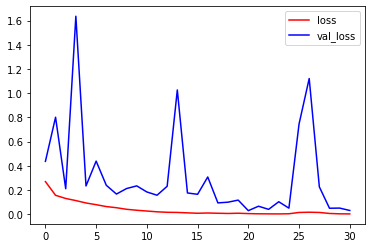

2022_06_09-09_57_30-new-params_1813057-batch_2048-history_binary_accuracy.jpg


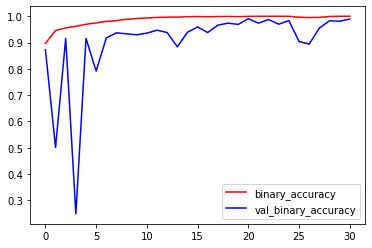

In [22]:
def draw_history(key):
    filename = f'{model_dir}-history_{key}.jpg'
    path = os.path.join(save_models, model_dir, filename)
    plt.plot(trainHistory.history[key], color='r', label=key)
    plt.plot(trainHistory.history[f'val_{key}'], color='b', label=f'val_{key}')
    plt.legend()
    print(filename)
    plt.savefig(path)
    plt.show()

draw_history('loss')
draw_history('binary_accuracy')

### 匯出模型

# 測試模型

In [23]:
best_model = load_model(os.path.join(save_models, model_dir, 'model.h5'))

In [24]:
best_model.evaluate(X_test, Y_test)

799/799 [==============================] - 9s 7ms/step - loss: 0.0292 - binary_accuracy: 0.9895


[0.029179025441408157, 0.9895099401473999]

In [26]:
predicted = best_model.predict(X_test)
predicts_classes = predicted > 0.5

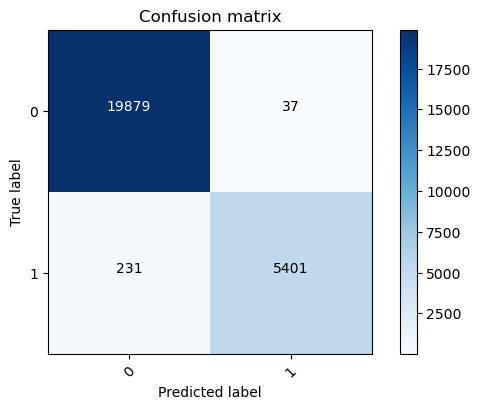

In [27]:
utils.plot_confusion_matrix(Y_test, predicts_classes, 2, dpi=100)